## Lesson 1 - Is it a anime character?

Nome: Beatriz Vieira Nascimento

Matricula: 211031628

Github: Beatrizvn

O objetivo deste artigo é aplicar o conhecimento adquirido na Lição 1 *Getting Started* do **Fast.ai** configurando um modelo de aprendizado que identifica imagens de personagens de anime.




## Step 0: Baixar algumas depedencias

In [1]:
# Você pode pular esta célula se já tiver instalado
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00


## Step 1: Baixar imagens de personagens de animes e personagens que não são de anime



Primeiro, foi escrita a função que será usada para instalar imagens usando *ddg_images* do *DuckDuckGo*

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Primeiro, vamos baixar imagens de 'anime characters'.

A função  *search_images* começa procurando por uma imagem, obtém URLs da pesquisa, e em seguida, a função *download_url* baixa a imagem da URL.

Salvamos a imagem baixada como *anime.jpg*.

Em seguida, podemos visualizar a imagem baixada.

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


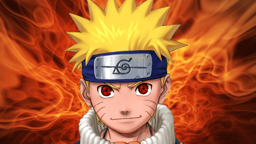

In [3]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('anime characters', max_images=1)[0], 'anime.jpg', show_progress=False)
Image.open('anime.jpg').to_thumb(256,256)

Agora vamos fazer o mesmo com "cartoon characters":

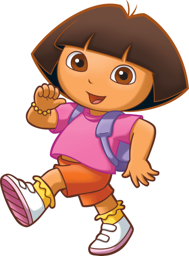

In [4]:
download_url(search_images('cartoon characters', max_images=1)[0], 'cartoon.jpg', show_progress=False)
Image.open('cartoon.jpg').to_thumb(256,256)

As pesquisas parecem estar fornecendo resultados bons, então vou pegar 300 exemplos de cada um das imagens de 'anime characters' e 'cartoon characters'.

Vamos salvar cada grupo de fotos em uma pasta diferente.

Observações:

1. A função sleep é usada para evitar dificuldades no tráfego de dados.
2. Vamos buscar imagens de anime e desenhos animados em geral, e também nos estilos dos anos 90 e 80.

In [5]:
searches = 'anime characters','cartoon characters'
path = Path('anime_characters_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} 90s style'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} 80s style'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Treinando o modelo


Algumas fotos podem não ser baixadas corretamente, o que pode fazer com que o treinamento do modelo falhe, portanto, vamos removê-las:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

53

Para treinar um modelo, precisaremos de `DataLoaders`, que é um objeto que contém um conjunto de treinamento (as imagens usadas para criar um modelo). Um conjunto de validação (as imagens usadas para verificar a precisão de um modelo - não são usadas durante o treinamento).

No `fastai`, podemos criar isso facilmente usando um `DataBlock` e visualizar amostras de imagens a partir dele:

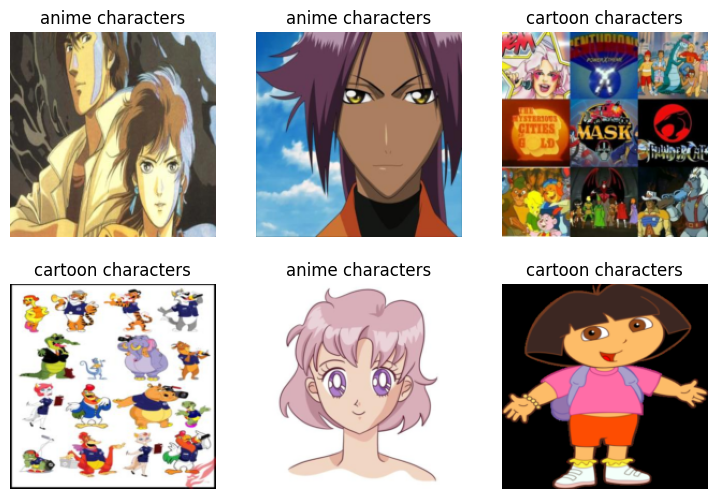

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Aqui está o que cada um dos parâmetros do `DataBlock` significa

    blocks=(ImageBlock, CategoryBlock),

As entradas para o nosso modelo são imagens, e as saídas são categorias (neste caso, 'anime characters' ou 'cartoon characters')

    get_items=get_image_files,

Para encontrar todas as entradas para o nosso modelo, execute a função `get_image_files` (que retorna uma lista de todos os arquivos de imagem em um caminho).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Divida os dados em conjuntos de treinamento e validação aleatoriamente, utilizando 20% dos dados para o conjunto de validação.

    get_y=parent_label,

Os rótulos (valores `y`) são o nome do `parent` de cada arquivo (ou seja, o nome da pasta em que estão, que será 'anime characters' ou 'cartoon characters'.

    item_tfms=[Resize(192, method='squish')]

Antes do treinamento, redimensione cada imagem para 192x192 pixels "esticando" (em vez de cortar).

Fonte: Course Fastai.

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o `resnet18`.

O *fastai* vem com um método útil chamado *fine_tune()* que automaticamente utiliza as melhores práticas para ajustar um modelo pré-treinado, então vamos usar isso.

"Fine-tuning" (ajuste fino) de um modelo significa que estamos começando com um modelo que alguém treinou usando algum outro conjunto de dados (chamado de modelo pré-treinado) e ajustando um pouco os pesos para que o modelo aprenda a reconhecer o seu conjunto de dados específico. Neste caso, o modelo pré-treinado foi treinado para reconhecer fotos no imagenet, um conjunto de dados de visão computacional amplamente utilizado com imagens que abrangem 1000 categorias. Fonte: Course Fastai.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.099153,0.967452,0.322581,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.415157,0.299898,0.129032,01:19
1,0.333908,0.271366,0.139785,01:22
2,0.236231,0.301642,0.129032,01:33


## Step 3: Usando o modelo



Vamos ver o que o modelo pensa sobre o personagem de anime que foi baixado no início.



In [9]:
is_anime,_,probs = learn.predict(PILImage.create('anime.jpg'))
print(f"This is a: {is_anime}.")
print(f"Probability it's a anime: {probs[0]:.4f}")

This is a: anime characters.
Probability it's a anime: 0.9837


E vamos ver o que nosso modelo pensa sobre aquele personagem de desenho animado que baixamos:




In [10]:
is_anime,_,probs = learn.predict(PILImage.create('cartoon.jpg'))
print(f"This is a: {is_anime}.")
print(f"Probability it's a anime: {probs[0]:.4f}")

This is a: cartoon characters.
Probability it's a anime: 0.0008


## Conclusão

É possivel notar que mesmo ambos se tratando de desenhos animados, apenas com estilos diferentes, a IA soube identificar o personagem de anime com precisão probabilística alta.

## Bibliographic References

---

[1] Course Fastai. Available at https://course.fast.ai/. Accessed on September 7, 2023

[2] Deep Learning for Coders with fastai & PyTorch. Available at  https://github.com/fastai/fastbook. Accessed on September 7, 2023
